<a href="https://colab.research.google.com/github/jinyingtld/python/blob/main/AI6126_tutorial_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4 MB 1.2 kB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.1+cu101 which is incompatible.


In [13]:
# Create a MNISTM dataset class
# MNISTM isn't supported by torchvision
#https://github.com/liyxi/mnist-m
import os
import warnings

import torch
from PIL import Image
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import download_and_extract_archive 


class MNISTM(VisionDataset):
    """
    MNIST-M Dataset.
    """

    resources = [
        ('https://github.com/liyxi/mnist-m/releases/download/data/mnist_m_train.pt.tar.gz',
         '191ed53db9933bd85cc9700558847391'),
        ('https://github.com/liyxi/mnist-m/releases/download/data/mnist_m_test.pt.tar.gz',
         'e11cb4d7fff76d7ec588b1134907db59')     
    ]

    training_file = "mnist_m_train.pt"
    test_file = "mnist_m_test.pt"
    classes = ['0 - zero','1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
    
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__(root, transform=transform, target_transform=target_transform)
        self.train=train

        if download:
            self.download()
        
        if not self._check_exists():
            raise RuntimeError("Dataset not found." + 
                               "You can use download=True to download it")
        
        if self.train:
            data_file=self.training_file
        else:
            data_file=self.test_file
        
        print(os.path.join(self.processed_folder,data_file))

        self.data, self.targets = torch.load(os.path.join(self.processed_folder,data_file))
    
    def __getitem__(self, index):
        """Get images and target for data loader.
        Args:
            index (int):Index
        returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.squeeze().numpy(), mode="RGB")

        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target
    
    def __len__(self):
        """Return size of dataset."""
        return len(self.data)

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets
    
    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targetrs")
        return self.targets
    
    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data
    
    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data
    
    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')
    
    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__,'processed')
    
    @property
    def class_to_idx(self):
        return {_class:i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder,self.training_file)) and 
                os.path.exists(os.path.join(self.processed_folder, self.test_file)))
    
    def download(self):
        """Download the MNIST-M data"""

        if self._check_exists():
            return
        
        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)
    
        # download files
        for url, md5 in self.resources:
            filename = url.rpartition('/')[2]
            download_and_extract_archive(url, download_root=self.raw_folder,
                                         extract_root=self.processed_folder,
                                         filename=filename, md5=md5)
        print("Done!")
    
    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")
    


In [4]:
# Import packages
import torch 
import torchvision
from torch import nn
from torch.autograd import Function
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms 
import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm # show progress bar 

In [5]:
# Make sure cuda is available 
print(f"CUDA is available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available: True


In [15]:
# Download datasets
# We use MNIST and MNIST-M in the tutorial
# MNIST: hand-written digits (28x28)
# MNIST-M: MNIST's background blended with random color patches
tfm1 = transforms.Compose([
    transforms.Grayscale(3), # convert to 3-channel
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
])

tfm2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=tfm1)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=tfm1)

mnistm_train = MNISTM(root="./data",train=True, download=True, transform=tfm2)
mnistm_test = MNISTM(root="./data",train=False, download=True, transform=tfm2)

print("** Dataset statistics**")

print("MNIST:")
print(f"- train: {len(mnist_train):,}")
print(f"- test: {len(mnist_test):,}")

print("MNIST-M:")
print(f"- train: {len(mnistm_train):,}")
print(f"- test: {len(mnistm_test):,}")

# Construct data loaders
source_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
source_test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

target_train_loader = DataLoader(mnistm_train, batch_size=128, shuffle=True)
target_test_loader = DataLoader(mnistm_test, batch_size=128, shuffle=False)

./data/MNISTM/processed/mnist_m_train.pt
./data/MNISTM/processed/mnist_m_test.pt
** Dataset statistics**
MNIST:
- train: 60,000
- test: 10,000
MNIST-M:
- train: 60,000
- test: 10,000


Visualize MNIST images


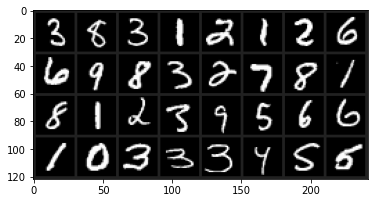

Visualize MNIST-M images


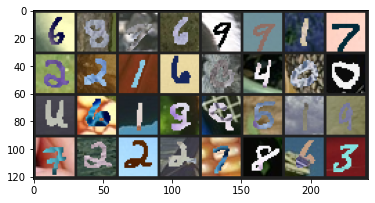

In [18]:
# Show some example images of the two datasets
def imshow(img, mean=0, std=1):
    img = img * std + mean # unnormalize
    npimg = img.numpy().transpose(1, 2, 0).squeeze() # (c, h, w) -> (h, w, c)
    plt.imshow(npimg)
    plt.show()

print("Visualize MNIST images")
img, _ = next(iter(source_train_loader))
img = img[:32, ...] # only show 32 images
img = torchvision.utils.make_grid(img)
imshow(img, 0.1307, 0.3081)

print("Visualize MNIST-M images")
img, _ = next(iter(target_train_loader))
img = img[:32, ...]   # only show 32 images
img = torchvision.utils.make_grid(img)
imshow(img, 0.1307, 0.3081)

In [19]:
# Define a CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # Call parent class's constructor
        self.conv1 = nn.Conv2d(3, 8, 5, 1)
        self.conv2 = nn.Conv2d(8, 16, 5, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*4*16, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        self.relu = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.conv1(x)
        x = self.relu(x)  # When a nn.Module is called, it will compute the result
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 4*4*16) # Flatten the data
        z = self.relu(self.fc1(x))
        z = self.relu(self.fc2(z))
        y = self.fc3(z)
        if return_feature:
            return y, x
        return y

In [20]:
# Global training param
max_epoch = 5

In [21]:
#####################################
# A source-only baseline
#####################################
baseline = SimpleCNN().to(device)
print(baseline)

# Build an optimizer 
optimizer = torch.optim.Adam(baseline.parameters(), 0.0003, weight_decay=5e-4)
# Choose a loss function
criterion = nn.CrossEntropyLoss()

# Construct a training loop
def train(model, optim, epoch, loader):
    model.train() # Set the model to be in train mode 

    for batch_index, (inputs, labels) in enumerate(loader):
        # Forward
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if batch_index % 100 == 0 or batch_index == len(loader)-1:
            print(f"epoch {epoch} batch {batch_index}/{len(loader)} loss {loss.item():.3f}")

        # Backward
        optim.zero_grad() # Set gradients to zero
        loss.backward() # From the loss we compute the new gradients
        optim.step() # Update the parameters/weights


SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)


In [22]:
# Create a test function 
def test(model, loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0) # Sum up batch loss
            preds = outputs.max(1, keepdim=True)[1] # Get the index of the max probability
            correct += preds.eq(labels.view_as(preds)).sum().item()
    
    test_loss /= len(loader.dataset)
    acc = correct / len(loader.dataset)
    print(f"Test Average loss: {test_loss:.4f}, Test Accuracy: {correct}/{len(loader.dataset)} ({100. * acc:.2f}%)")

    return acc

In [23]:
# do the training 
meter_bl_acc_s = []
meter_bl_acc_t = []
for ep in range(max_epoch):
    train(baseline, optimizer, ep, source_train_loader)
    print("Evaluate on the source test set")
    acc_s = test(baseline, source_test_loader)
    meter_bl_acc_s.append(acc_s)
    print("Evaluate on the target test set")
    acc_t = test(baseline, target_test_loader)
    meter_bl_acc_t.append(acc_t)

epoch 0 batch 0/469 loss 2.304
epoch 0 batch 100/469 loss 0.830
epoch 0 batch 200/469 loss 0.372
epoch 0 batch 300/469 loss 0.299
epoch 0 batch 400/469 loss 0.262
epoch 0 batch 468/469 loss 0.272
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 34.81it/s]


Test Average loss: 0.2518, Test Accuracy: 9247/10000 (92.47%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 50.45it/s]


Test Average loss: 4.8313, Test Accuracy: 2857/10000 (28.57%)
epoch 1 batch 0/469 loss 0.243
epoch 1 batch 100/469 loss 0.290
epoch 1 batch 200/469 loss 0.191
epoch 1 batch 300/469 loss 0.147
epoch 1 batch 400/469 loss 0.191
epoch 1 batch 468/469 loss 0.176
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 35.35it/s]


Test Average loss: 0.1383, Test Accuracy: 9585/10000 (95.85%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 51.84it/s]


Test Average loss: 4.4696, Test Accuracy: 3154/10000 (31.54%)
epoch 2 batch 0/469 loss 0.116
epoch 2 batch 100/469 loss 0.174
epoch 2 batch 200/469 loss 0.091
epoch 2 batch 300/469 loss 0.119
epoch 2 batch 400/469 loss 0.085
epoch 2 batch 468/469 loss 0.142
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 35.27it/s]


Test Average loss: 0.1113, Test Accuracy: 9658/10000 (96.58%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 51.76it/s]


Test Average loss: 3.9768, Test Accuracy: 3412/10000 (34.12%)
epoch 3 batch 0/469 loss 0.208
epoch 3 batch 100/469 loss 0.205
epoch 3 batch 200/469 loss 0.115
epoch 3 batch 300/469 loss 0.040
epoch 3 batch 400/469 loss 0.091
epoch 3 batch 468/469 loss 0.124
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 35.66it/s]


Test Average loss: 0.0822, Test Accuracy: 9722/10000 (97.22%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 51.85it/s]


Test Average loss: 3.7351, Test Accuracy: 3358/10000 (33.58%)
epoch 4 batch 0/469 loss 0.123
epoch 4 batch 100/469 loss 0.135
epoch 4 batch 200/469 loss 0.039
epoch 4 batch 300/469 loss 0.098
epoch 4 batch 400/469 loss 0.050
epoch 4 batch 468/469 loss 0.050
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 34.77it/s]


Test Average loss: 0.0691, Test Accuracy: 9782/10000 (97.82%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 52.49it/s]

Test Average loss: 3.1716, Test Accuracy: 3716/10000 (37.16%)


In [27]:
# Gradient reversal layer (https://github.com/KaiyangZhou/Dassl.pytorch)  
# https://blog.csdn.net/tsq292978891/article/details/79364140
class _ReverseGrad(Function): # torch.autograd 的Function的子类, 求导的.
    @staticmethod
    def forward(ctx, input, grad_scaling): # ctx is a context object that can be used to stash information for backward computation
        ctx.grad_scaling = grad_scaling
        return input.view_as(input)
    
    @staticmethod 
    def backward(ctx, grad_output):
        grad_scaling = ctx.grad_scaling
        return -grad_scaling * grad_output, None

reverse_grad = _ReverseGrad.apply

class ReverseGrad(nn.Module):
    """Gradient reversal layer.
    It acts as an identity layer in the forward, 
    but reverses the sign of the gradient in the backward.
    """

    def forward(self, x, grad_scaling=1.0):
        assert (grad_scaling >= 0), "grad_scaling must be non-negative, " "but got {}".format(grad_scaling)

        return reverse_grad(x, grad_scaling)


In [28]:
#####################################
# Domain-adversarial training
# https://github.com/KaiyangZhou/Dassl.pytorch
#####################################
dann = SimpleCNN().to(device)
critic = nn.Sequential(
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
).to(device)
revgrad = ReverseGrad()

print(dann)
print(critic)

# Build an optimizer
optimizer = torch.optim.Adam(dann.parameters(), 0.0003, weight_decay=5e-4)
optimizer_critic = torch.optim.Adam(critic.parameters(), 0.0003, weight_decay=5e-4)
# Choose a loss function
criterion = nn.CrossEntropyLoss()
criterion_bce = nn.BCEWithLogitsLoss()

# Construct a training loop
def train_dann(model, discriminator, optim, optim_d, epoch, loader_s, loader_t, d_weight):
    model.train() # Set the model to be in training mode
    discriminator.train()

    loader_t_iter = iter(loader_t)

    for batch_index, (inputs_s, labels_s) in enumerate(loader_s):
        try: 
            inputs_t, _ = next(loader_t_iter)
        except StopIteration:
            loader_t_iter = iter(loader_t)
            inputs_t, _ = next(loader_t_iter)

        global_step = batch_index + epoch * len(loader_s)
        progress = global_step / (max_epoch * len(loader_s))
        lmda = 2 / (1 + np.exp(-10 * progress)) - 1

        inputs_s, labels_s, inputs_t = inputs_s.to(device), labels_s.to(device), inputs_t.to(device)

        # Initialize domain labels
        ones = torch.ones(inputs_s.shape[0],1).to(device)
        zeros = torch.zeros(inputs_t.shape[0],1).to(device)

        # Forward
        outputs_s, features_s = model(inputs_s, return_feature=True)
        _, features_t = model(inputs_t, return_feature=True)

        #  Loss for labeled source data 
        loss_s = criterion(outputs_s, labels_s)

        # Domain-adversarial loss 
        features_s = revgrad(features_s, grad_scaling=lmda)
        features_t = revgrad(features_t, grad_scaling=lmda)
        domains_s = critic(features_s)
        domains_t = critic(features_t)
        loss_d = criterion_bce(domains_s, ones) + criterion_bce(domains_t, zeros)

        loss = loss_s +loss_d * d_weight

        if batch_index % 100 == 0 or batch_index == len(loader_s)-1:
            print(f"epoch {epoch}  batch {batch_index}/{len(loader_s)}  loss_s {loss_s.item():.3f}  loss_d {loss_d.item():.3f}  lmda {lmda:.3f}")

        # Backward
        optim.zero_grad()  # Set gradients to zero
        optim_d.zero_grad()
        loss.backward()    # From the loss we compute the new gradients
        optim.step()       # Update the parameters/weights
        optim_d.step()


SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)
Sequential(
  (0): Linear(in_features=256, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)


In [29]:
# Do the training
meter_dn_acc_s = []
meter_dn_acc_t = []
d_weight = 1.
for ep in range(max_epoch):
    train_dann(dann, critic, optimizer, optimizer_critic, ep, source_train_loader, target_train_loader, d_weight)
    print("Evaluate on the source test set")
    acc_s = test(dann, source_test_loader)
    meter_dn_acc_s.append(acc_s)
    print("Evaluate on the target test set")
    acc_t = test(dann, target_test_loader)
    meter_dn_acc_t.append(acc_t)

epoch 0  batch 0/469  loss_s 2.309  loss_d 1.380  lmda 0.000
epoch 0  batch 100/469  loss_s 1.197  loss_d 5.746  lmda 0.210
epoch 0  batch 200/469  loss_s 0.389  loss_d 0.393  lmda 0.402
epoch 0  batch 300/469  loss_s 0.364  loss_d 0.978  lmda 0.565
epoch 0  batch 400/469  loss_s 0.406  loss_d 1.025  lmda 0.693
epoch 0  batch 468/469  loss_s 0.240  loss_d 1.234  lmda 0.761
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 35.32it/s]


Test Average loss: 0.3027, Test Accuracy: 9092/10000 (90.92%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 51.47it/s]


Test Average loss: 2.3240, Test Accuracy: 3977/10000 (39.77%)
epoch 1  batch 0/469  loss_s 0.357  loss_d 1.142  lmda 0.762
epoch 1  batch 100/469  loss_s 0.264  loss_d 0.505  lmda 0.838
epoch 1  batch 200/469  loss_s 0.235  loss_d 0.790  lmda 0.891
epoch 1  batch 300/469  loss_s 0.164  loss_d 1.356  lmda 0.927
epoch 1  batch 400/469  loss_s 0.217  loss_d 1.006  lmda 0.952
epoch 1  batch 468/469  loss_s 0.266  loss_d 1.389  lmda 0.964
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 35.59it/s]


Test Average loss: 0.1958, Test Accuracy: 9392/10000 (93.92%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 52.10it/s]


Test Average loss: 1.9827, Test Accuracy: 4866/10000 (48.66%)
epoch 2  batch 0/469  loss_s 0.159  loss_d 1.368  lmda 0.964
epoch 2  batch 100/469  loss_s 0.250  loss_d 1.185  lmda 0.976
epoch 2  batch 200/469  loss_s 0.267  loss_d 0.626  lmda 0.985
epoch 2  batch 300/469  loss_s 0.119  loss_d 0.601  lmda 0.990
epoch 2  batch 400/469  loss_s 0.180  loss_d 0.719  lmda 0.993
epoch 2  batch 468/469  loss_s 0.263  loss_d 1.232  lmda 0.995
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 35.97it/s]


Test Average loss: 0.2294, Test Accuracy: 9298/10000 (92.98%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 53.07it/s]


Test Average loss: 2.1576, Test Accuracy: 4032/10000 (40.32%)
epoch 3  batch 0/469  loss_s 0.217  loss_d 1.225  lmda 0.995
epoch 3  batch 100/469  loss_s 0.203  loss_d 0.814  lmda 0.997
epoch 3  batch 200/469  loss_s 0.119  loss_d 0.817  lmda 0.998
epoch 3  batch 300/469  loss_s 0.309  loss_d 1.247  lmda 0.999
epoch 3  batch 400/469  loss_s 0.206  loss_d 0.262  lmda 0.999
epoch 3  batch 468/469  loss_s 0.151  loss_d 0.389  lmda 0.999
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 35.05it/s]


Test Average loss: 0.1684, Test Accuracy: 9479/10000 (94.79%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 48.45it/s]


Test Average loss: 2.4298, Test Accuracy: 4603/10000 (46.03%)
epoch 4  batch 0/469  loss_s 0.312  loss_d 0.482  lmda 0.999
epoch 4  batch 100/469  loss_s 0.218  loss_d 0.457  lmda 1.000
epoch 4  batch 200/469  loss_s 0.243  loss_d 0.222  lmda 1.000
epoch 4  batch 300/469  loss_s 0.126  loss_d 0.581  lmda 1.000
epoch 4  batch 400/469  loss_s 0.234  loss_d 0.503  lmda 1.000
epoch 4  batch 468/469  loss_s 0.123  loss_d 0.667  lmda 1.000
Evaluate on the source test set


100%|██████████| 79/79 [00:02<00:00, 36.09it/s]


Test Average loss: 0.1687, Test Accuracy: 9485/10000 (94.85%)
Evaluate on the target test set


100%|██████████| 79/79 [00:01<00:00, 52.10it/s]

Test Average loss: 2.3641, Test Accuracy: 4899/10000 (48.99%)


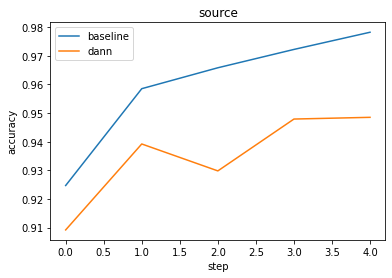

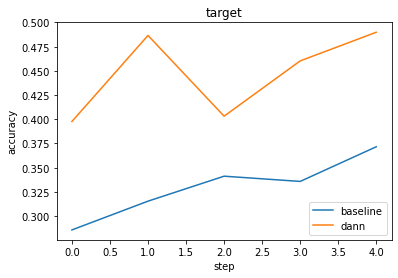

In [30]:
# Plot test accuracy curves
plt.plot(range(len(meter_bl_acc_s)), meter_bl_acc_s, label="baseline")
plt.plot(range(len(meter_dn_acc_s)), meter_dn_acc_s, label="dann")
plt.legend()
plt.xlabel("step")
plt.ylabel("accuracy")
plt.title("source")
plt.show()

plt.plot(range(len(meter_bl_acc_t)), meter_bl_acc_t, label="baseline")
plt.plot(range(len(meter_dn_acc_t)), meter_dn_acc_t, label="dann")
plt.legend()
plt.xlabel("step")
plt.ylabel("accuracy")
plt.title("target")
plt.show()